In [8]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install statsmodels
!pip install pandas_datareader
#!pip install datatime
!pip install yfinance
!pip install scikit-learn
!pip install PyPortfolioOpt
!pip install pandas_ta

In [21]:
from statsmodels.regression.rolling import RollingOLS
#from datetime import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S&P_500_companies')[0] #gets data from wikipedia#

sp500["Symbol"] = sp500["Symbol"].str.replace(".", "-") #cleans data for symbols#

symbols_list = sp500['Symbol'].unique().tolist() # makes list of symbols #

end_date = "2024-10-04" #sets end Date#

start_date = pd.to_datetime(end_date) - pd.DateOffset(365*10)

start_date

df = yf.download(tickers=symbols_list, start=start_date, end=end_date, auto_adjust=False).stack() #downloads data from yf and makes a stack with it#

df.index.names = ['date', 'ticker']

[*********************100%***********************]  503 of 503 completed


In [23]:
df.unstack()

df.columns = df.columns.str.lower()

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2014-10-07 A        36.066105   39.341915   40.293278   39.341915   40.236053   
           AAPL     21.843422   24.687500   25.030001   24.682501   24.857500   
           ABBV     36.492260   56.650002   57.599998   56.509998   57.599998   
           ABT      33.750320   41.459999   42.180000   41.450001   42.090000   
           ACGL     17.366575   18.263332   18.413334   18.260000   18.350000   
...                       ...         ...         ...         ...         ...   
2024-10-03 XYL     132.278259  133.059998  134.089996  131.979996  134.089996   
           YUM     135.906128  137.210007  138.660004  137.199997  138.639999   
           ZBH     103.733772  104.190002  105.750000  103.820000  105.320000   
           ZBRA    363.890015  363.890015  368.170013  362.619995  365.989990   
           ZTS     189.325333  190.990005  192.330002  190.000000  191.889999   

Price                   volume  
date       ticker               
2014-10-07 A         2117271.0  
           AAPL    168376800.0  
           ABBV      8923500.0  
           ABT       5178200.0  
           ACGL      1255200.0  
...                        ...  
2024-10-03 XYL       1007800.0  
           YUM       1993400.0  
           ZBH       1910100.0  
           ZBRA       302800.0  
           ZTS       1325000.0  

[1224847 rows x 6 columns]

2. Calculate the features and technical indicators for each stock.
   1. Garman-Klass Volitility
   2. RSI
   3. Bollinger Bands
   4. ATR
   5. MACD
   6. Dollar Volume
  
      Garman-Klass Volitility = [(ln(High)-ln(low))^2 / 2] - [(2ln(2) - 1)(ln(Adj Close) - ln(Open))^2]

      Used Usually in Forex trading it provides an estimate of the intraday volitility of a given asset. Can be used for stocks as well.

In [25]:
df['garmin_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['adj close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())
    
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2014-10-07 A        36.066105   39.341915   40.293278   39.341915   40.236053   
           AAPL     21.843422   24.687500   25.030001   24.682501   24.857500   
           ABBV     36.492260   56.650002   57.599998   56.509998   57.599998   
           ABT      33.750320   41.459999   42.180000   41.450001   42.090000   
           ACGL     17.366575   18.263332   18.413334   18.260000   18.350000   
...                       ...         ...         ...         ...         ...   
2024-10-03 XYL     132.278259  133.059998  134.089996  131.979996  134.089996   
           YUM     135.906128  137.210007  138.660004  137.199997  138.639999   
           ZBH     103.733772  104.190002  105.750000  103.820000  105.320000   
           ZBRA    363.890015  363.890015  368.170013  362.619995  365.989990   
           ZTS     189.325333  190.990005  192.330002  190.000000  191.889999   

Price                   volume  garmin_klass_vol        rsi    bb_low  \
date       ticker                                                       
2014-10-07 A         2117271.0         -0.004339        NaN       NaN   
           AAPL    168376800.0         -0.006357        NaN       NaN   
           ABBV      8923500.0         -0.080291        NaN       NaN   
           ABT       5178200.0         -0.018684        NaN       NaN   
           ACGL      1255200.0         -0.001137        NaN       NaN   
...                        ...               ...        ...       ...   
2024-10-03 XYL       1007800.0          0.000054  49.330128  4.854531   
           YUM       1993400.0         -0.000097  55.382172  4.852174   
           ZBH       1910100.0          0.000081  39.506847  4.647936   
           ZBRA       302800.0          0.000103  59.098207  5.781280   
           ZTS       1325000.0          0.000004  53.496866  5.238088   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2014-10-07 A            NaN       NaN       NaN       NaN      83.297496  
           AAPL         NaN       NaN       NaN       NaN    4156.802250  
           ABBV         NaN       NaN       NaN       NaN     505.516289  
           ABT          NaN       NaN       NaN       NaN     214.688167  
           ACGL         NaN       NaN       NaN       NaN      22.924135  
...                     ...       ...       ...       ...            ...  
2024-10-03 XYL     4.889638  4.924745 -2.021676  0.091808     134.097866  
           YUM     4.899271  4.946369 -2.629187  0.778775     273.514427  
           ZBH     4.669946  4.691955 -2.069274 -0.415730     199.013324  
           ZBRA    5.870433  5.959586  0.244182  1.068525     110.185896  
           ZTS     5.258625  5.279162 -0.839985  0.695415     253.061757  

[1224847 rows x 14 columns]

3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

   1. To reduce the training time as well as to experiment with features and stategies, we convert the business-daily data to month-end frequency.

In [88]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'), 
           df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1)).dropna()

data

dollar_volume   adj close  garmin_klass_vol        rsi  \
date       ticker                                                           
2014-11-30 A          122.546905   39.181267         -0.002876  67.954908   
           AAPL      4904.917289   26.421299         -0.005584  80.558146   
           ABBV       414.309702   44.909145         -0.071212  76.357745   
           ABT        184.100571   36.425663         -0.015281  64.020471   
           ACGL        27.891787   18.168501         -0.001039  60.878953   
...                          ...         ...               ...        ...   
2024-10-31 XYL        146.107029  132.278259          0.000054  49.330128   
           YUM        249.816813  135.906128         -0.000097  55.382172   
           ZBH        174.133466  103.733772          0.000081  39.506847   
           ZBRA       115.199449  363.890015          0.000103  59.098207   
           ZTS        289.924995  189.325333          0.000004  53.496866   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2014-11-30 A       3.621035  3.661491  3.701946 -0.278478  0.404654  
           AAPL    3.193371  3.260894  3.328417 -0.179471  0.203339  
           ABBV    3.697744  3.763433  3.829123  0.942790  0.913269  
           ABT     3.592325  3.608728  3.625131  0.489508  0.272758  
           ACGL    2.938299  2.949575  2.960850 -1.102002 -0.100377  
...                     ...       ...       ...       ...       ...  
2024-10-31 XYL     4.854531  4.889638  4.924745 -2.021676  0.091808  
           YUM     4.852174  4.899271  4.946369 -2.629187  0.778775  
           ZBH     4.647936  4.669946  4.691955 -2.069274 -0.415730  
           ZBRA    5.781280  5.870433  5.959586  0.244182  1.068525  
           ZTS     5.238088  5.258625  5.279162 -0.839985  0.695415  

[58445 rows x 9 columns]

    Calculate 5-year rolling average of dollar volume for each stock before filtering.

In [90]:
# The operations below are required. Only commented due to errors. required to run only once.

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garmin_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-10-31 AAPL     59.966991          0.000845  68.908189  4.002903   
           ABBV     63.013073         -0.021263  70.481037  4.050569   
           ABT      75.877335         -0.003637  54.403544  4.279020   
           ACN     170.709808         -0.002700  47.064256  5.123700   
           ADBE    277.929993          0.000104  51.985924  5.570602   
...                       ...               ...        ...       ...   
2024-10-31 VZ       42.391575         -0.001225  60.266796  3.721815   
           WDAY    240.940002          0.000279  47.752994  5.475203   
           WFC      54.099659         -0.000018  48.427273  3.958175   
           WMT      79.839386          0.000029  63.139411  4.350842   
           XOM     119.403358          0.000003  61.874862  4.669987   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2019-10-31 AAPL    4.063752  4.124600 -0.839810  0.515211  
           ABBV    4.110761  4.170953 -0.314630  0.762672  
           ABT     4.315704  4.352388  0.653025  0.041728  
           ACN     5.143369  5.163037  0.262327 -0.501687  
           ADBE    5.610361  5.650119 -0.389351 -0.299695  
...                     ...       ...       ...       ...  
2024-10-31 VZ      3.762484  3.803153 -2.049518  1.720925  
           WDAY    5.515171  5.555139  0.376198 -0.323621  
           WFC     4.002627  4.047080 -1.388851 -0.101198  
           WMT     4.382197  4.413552 -1.743293  2.533680  
           XOM     4.728155  4.786322 -1.404988  1.048923  

[9089 rows x 8 columns]

4. Calculate Monthly Returns for different time horizons as features.

   1. To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using method .pct_change(lag), i.e., returns over various monthly periods as identified by lags.

In [92]:
def calculate_returns(df):
    
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), 
                                                       upper=x.quantile(1-outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
        
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garmin_klass_vol        rsi    bb_low  \
date       ticker                                                      
2020-10-31 AAPL    106.010231         -0.000081  43.770308  4.681436   
           ABBV     71.141037         -0.008782  47.517595  4.230616   
           ABT      96.892761         -0.002085  48.047149  4.581505   
           ACN     202.907410         -0.001167  42.280818  5.305017   
           ADBE    447.100006          0.000472  39.586497  6.119939   
...                       ...               ...        ...       ...   
2024-10-31 VZ       42.391575         -0.001225  60.266796  3.721815   
           WDAY    240.940002          0.000279  47.752994  5.475203   
           WFC      54.099659         -0.000018  48.427273  3.958175   
           WMT      79.839386          0.000029  63.139411  4.350842   
           XOM     119.403358          0.000003  61.874862  4.669987   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2020-10-31 AAPL    4.740252  4.799068  1.562690 -0.611482  -0.060012   
           ABBV    4.273986  4.317357 -0.575658 -0.964497  -0.015197   
           ABT     4.608834  4.636162  1.214555 -0.058776  -0.030963   
           ACN     5.354047  5.403077  0.363420 -0.901891  -0.036420   
           ADBE    6.192112  6.264286  0.998973 -0.976808  -0.088351   
...                     ...       ...       ...       ...        ...   
2024-10-31 VZ      3.762484  3.803153 -2.049518  1.720925  -0.008684   
           WDAY    5.515171  5.555139  0.376198 -0.323621  -0.014197   
           WFC     4.002627  4.047080 -1.388851 -0.101198  -0.026730   
           WMT     4.382197  4.413552 -1.743293  2.533680  -0.003963   
           XOM     4.728155  4.786322 -1.404988  1.048923   0.045726   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2020-10-31 AAPL    -0.081515   0.008696   0.068576   0.039452    0.048624  
           ABBV    -0.050954  -0.031357   0.010106   0.010004    0.010161  
           ABT     -0.018485   0.015717   0.023513   0.022346    0.020583  
           ACN     -0.047322  -0.010521   0.027996   0.007530    0.014503  
           ADBE    -0.066792   0.002081   0.039858   0.027208    0.040413  
...                      ...        ...        ...        ...         ...  
2024-10-31 VZ       0.032270   0.031879   0.022947   0.009183    0.024111  
           WDAY    -0.043203   0.019885  -0.002598  -0.020783    0.010836  
           WFC     -0.030304  -0.022641  -0.010385   0.012488    0.029860  
           WMT      0.020507   0.055259   0.052606   0.044082    0.034166  
           XOM      0.019481   0.013798   0.008688   0.022612    0.015215  

[6934 rows x 14 columns]

5. Download Fama-French Factors and Calculate Rolling Factor Betas.
   1. We will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regression.
   2. The five Fama-French facotrs, namely market risk, size, value, operating profitability, and investment have been shown to empirically explain asset returns in the past and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.
   3. We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.
  
Link to Fama-French Library: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html 

In [141]:
# We will only be using 5 factors and not the RF or Risk Free Return which is more complex and gives us the data on the 3-month
# US treasury interest rate at the time. This is due to the fact that there exists no truly risk free return, but the US 
# treaury bond rates for 3-months gets close to one as the US government never defaults on a loan.

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2009')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp().tz_localize('UTC')

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

data['return_1m'].index.name = 'date'

factor_data.index = factor_data.index.tz_localize(None)

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

data

garmin_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2020-10-31 AAPL           -0.000081  43.770308  4.681436  4.740252  4.799068   
           ABBV           -0.008782  47.517595  4.230616  4.273986  4.317357   
           ABT            -0.002085  48.047149  4.581505  4.608834  4.636162   
           ACN            -0.001167  42.280818  5.305017  5.354047  5.403077   
           ADBE            0.000472  39.586497  6.119939  6.192112  6.264286   
...                             ...        ...       ...       ...       ...   
2024-10-31 VZ             -0.001225  60.266796  3.721815  3.762484  3.803153   
           WDAY            0.000279  47.752994  5.475203  5.515171  5.555139   
           WFC            -0.000018  48.427273  3.958175  4.002627  4.047080   
           WMT             0.000029  63.139411  4.350842  4.382197  4.413552   
           XOM             0.000003  61.874862  4.669987  4.728155  4.786322   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2020-10-31 AAPL    1.562690 -0.611482  -0.060012  -0.081515   0.008696   
           ABBV   -0.575658 -0.964497  -0.015197  -0.050954  -0.031357   
           ABT     1.214555 -0.058776  -0.030963  -0.018485   0.015717   
           ACN     0.363420 -0.901891  -0.036420  -0.047322  -0.010521   
           ADBE    0.998973 -0.976808  -0.088351  -0.066792   0.002081   
...                     ...       ...        ...        ...        ...   
2024-10-31 VZ     -2.049518  1.720925  -0.008684   0.032270   0.031879   
           WDAY    0.376198 -0.323621  -0.014197  -0.043203   0.019885   
           WFC    -1.388851 -0.101198  -0.026730  -0.030304  -0.022641   
           WMT    -1.743293  2.533680  -0.003963   0.020507   0.055259   
           XOM    -1.404988  1.048923   0.045726   0.019481   0.013798   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2020-10-31 AAPL     0.068576   0.039452    0.048624  1.189384 -0.069168   
           ABBV     0.010106   0.010004    0.010161  0.432831 -0.046226   
           ABT      0.023513   0.022346    0.020583  0.725160  0.037751   
           ACN      0.027996   0.007530    0.014503  1.229091 -0.290777   
           ADBE     0.039858   0.027208    0.040413  1.609071 -0.784592   
...                      ...        ...         ...       ...       ...   
2024-10-31 VZ       0.022947   0.009183    0.024111  0.551217 -0.794724   
           WDAY    -0.002598  -0.020783    0.010836  1.042931 -0.777035   
           WFC     -0.010385   0.012488    0.029860  1.111302 -0.195849   
           WMT      0.052606   0.044082    0.034166  0.692433  0.007579   
           XOM      0.008688   0.022612    0.015215  0.626538 -0.088668   

                        HML       RMW       CMA  
date       ticker                                
2020-10-31 AAPL   -0.463136  0.217854 -0.023208  
           ABBV   -0.170348  0.338966  0.852960  
           ABT    -0.332178  0.237258  0.867786  
           ACN    -0.237951  0.235871 -0.047329  
           ADBE   -0.151535  0.242680 -0.142763  
...                     ...       ...       ...  
2024-10-31 VZ      0.392521 -0.039016 -0.108910  
           WDAY   -0.192547 -1.650509  0.066972  
           WFC     1.359174 -0.781410 -0.841155  
           WMT    -0.174171  1.172892  0.056636  
           XOM     0.433800  0.783136  0.826414  

[6709 rows x 18 columns]

    Filter out stocks with less than 10 months of data.

In [132]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

# return all the stocks ticker part of index
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2020-10-31 AAPL   -0.0208  0.0467  0.0425 -0.0077 -0.0057  -0.060012
           ABBV   -0.0208  0.0467  0.0425 -0.0077 -0.0057  -0.015197
           ABT    -0.0208  0.0467  0.0425 -0.0077 -0.0057  -0.030963
           ACN    -0.0208  0.0467  0.0425 -0.0077 -0.0057  -0.036420
           ADBE   -0.0208  0.0467  0.0425 -0.0077 -0.0057  -0.088351
...                   ...     ...     ...     ...     ...        ...
2024-10-31 VZ     -0.0100 -0.0088  0.0086 -0.0142  0.0098  -0.008684
           WDAY   -0.0100 -0.0088  0.0086 -0.0142  0.0098  -0.014197
           WFC    -0.0100 -0.0088  0.0086 -0.0142  0.0098  -0.026730
           WMT    -0.0100 -0.0088  0.0086 -0.0142  0.0098  -0.003963
           XOM    -0.0100 -0.0088  0.0086 -0.0142  0.0098   0.045726

[6709 rows x 6 columns]

    Calculate Rolling Factor Betas.
    Link to doc for Rolling Ols: https://www.statsmodels.org/dev/generated/statsmodels.regression.rolling.RollingOLS.html

In [134]:
betas = (factor_data.groupby(level=1, group_keys=False).apply(lambda x: RollingOLS(endog=x['return_1m'],
                             exog=sm.add_constant(x.drop('return_1m', axis=1)), window=min(24, x.shape[0])
                             , min_nobs=len(x.columns)+1).fit(params_only=True).params.drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2020-10-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-10-31 VZ      0.704146 -0.774474  0.428357  0.122879  0.117860
           WDAY    1.060564 -0.735018 -0.211262 -1.516910 -0.031073
           WFC     1.070168 -0.165430  1.328886 -0.721078 -1.014398
           WMT     0.657865 -0.006915 -0.176562  1.107574  0.036416
           XOM     0.322302 -0.146933  0.372860  0.408988  0.431547

[6709 rows x 5 columns]

In [143]:
#This is required only commented due to code execution requirements

# factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# data = (data.join(betas.groupby('ticker').shift()))

# data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

# data = data.drop('adj close', axis=1)

# data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6709 entries, (Timestamp('2020-10-31 00:00:00'), 'AAPL') to (Timestamp('2024-10-31 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garmin_klass_vol  6709 non-null   float64
 1   rsi               6709 non-null   float64
 2   bb_low            6709 non-null   float64
 3   bb_mid            6709 non-null   float64
 4   bb_high           6709 non-null   float64
 5   atr               6709 non-null   float64
 6   macd              6709 non-null   float64
 7   return_1m         6709 non-null   float64
 8   return_2m         6709 non-null   float64
 9   return_3m         6709 non-null   float64
 10  return_6m         6709 non-null   float64
 11  return_9m         6709 non-null   float64
 12  return_12m        6709 non-null   float64
 13  Mkt-RF            6709 non-null   float64
 14  SMB               6709 non-null   float64
 15  HML        

At this point we have to decide on what ML model and approach to use for pridictions etc.

6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

K-Means Cluster
    1. You may want to initialize predefined centroids for each cluster based on your research.
    2. For visulaization purpose of this demo we will initially rely on the 'k-means++' initialization.
    3. Then we will pre-define our centroids for each cluster.

We will be using 4 cluster for each months prediction.
K-Means Cluster docs: https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html

In [181]:
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis=1)

def get_clusters(df):
    df["cluster"] = KMeans(n_clusters=4, random_state=0, init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garmin_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2020-10-31 AAPL           -0.000081  43.770308  4.681436  4.740252  4.799068   
           ABBV           -0.008782  47.517595  4.230616  4.273986  4.317357   
           ABT            -0.002085  48.047149  4.581505  4.608834  4.636162   
           ACN            -0.001167  42.280818  5.305017  5.354047  5.403077   
           ADBE            0.000472  39.586497  6.119939  6.192112  6.264286   
...                             ...        ...       ...       ...       ...   
2024-10-31 VZ             -0.001225  60.266796  3.721815  3.762484  3.803153   
           WDAY            0.000279  47.752994  5.475203  5.515171  5.555139   
           WFC            -0.000018  48.427273  3.958175  4.002627  4.047080   
           WMT             0.000029  63.139411  4.350842  4.382197  4.413552   
           XOM             0.000003  61.874862  4.669987  4.728155  4.786322   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2020-10-31 AAPL    1.562690 -0.611482  -0.060012  -0.081515   0.008696   
           ABBV   -0.575658 -0.964497  -0.015197  -0.050954  -0.031357   
           ABT     1.214555 -0.058776  -0.030963  -0.018485   0.015717   
           ACN     0.363420 -0.901891  -0.036420  -0.047322  -0.010521   
           ADBE    0.998973 -0.976808  -0.088351  -0.066792   0.002081   
...                     ...       ...        ...        ...        ...   
2024-10-31 VZ     -2.049518  1.720925  -0.008684   0.032270   0.031879   
           WDAY    0.376198 -0.323621  -0.014197  -0.043203   0.019885   
           WFC    -1.388851 -0.101198  -0.026730  -0.030304  -0.022641   
           WMT    -1.743293  2.533680  -0.003963   0.020507   0.055259   
           XOM    -1.404988  1.048923   0.045726   0.019481   0.013798   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2020-10-31 AAPL     0.068576   0.039452    0.048624  1.189384 -0.069168   
           ABBV     0.010106   0.010004    0.010161  0.432831 -0.046226   
           ABT      0.023513   0.022346    0.020583  0.725160  0.037751   
           ACN      0.027996   0.007530    0.014503  1.229091 -0.290777   
           ADBE     0.039858   0.027208    0.040413  1.609071 -0.784592   
...                      ...        ...         ...       ...       ...   
2024-10-31 VZ       0.022947   0.009183    0.024111  0.551217 -0.794724   
           WDAY    -0.002598  -0.020783    0.010836  1.042931 -0.777035   
           WFC     -0.010385   0.012488    0.029860  1.111302 -0.195849   
           WMT      0.052606   0.044082    0.034166  0.692433  0.007579   
           XOM      0.008688   0.022612    0.015215  0.626538 -0.088668   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2020-10-31 AAPL   -0.463136  0.217854 -0.023208        1  
           ABBV   -0.170348  0.338966  0.852960        1  
           ABT    -0.332178  0.237258  0.867786        1  
           ACN    -0.237951  0.235871 -0.047329        1  
           ADBE   -0.151535  0.242680 -0.142763        0  
...                     ...       ...       ...      ...  
2024-10-31 VZ      0.392521 -0.039016 -0.108910        2  
           WDAY   -0.192547 -1.650509  0.066972        1  
           WFC     1.359174 -0.781410 -0.841155        1  
           WMT    -0.174171  1.172892  0.056636        3  
           XOM     0.433800  0.783136  0.826414        3  

[6709 rows x 19 columns]

In [183]:
# Data visualization plot function

def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]
    
    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:,1], color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:,1], color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:,1], color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:,1], color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

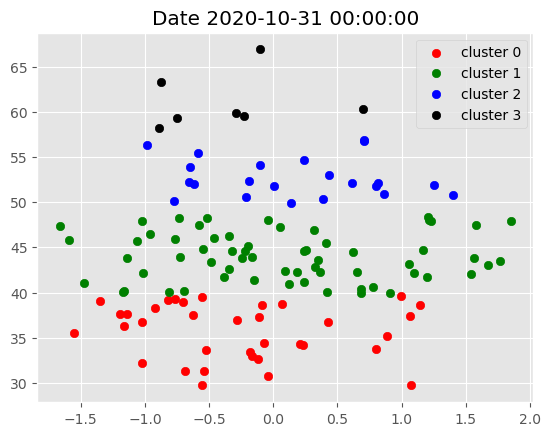

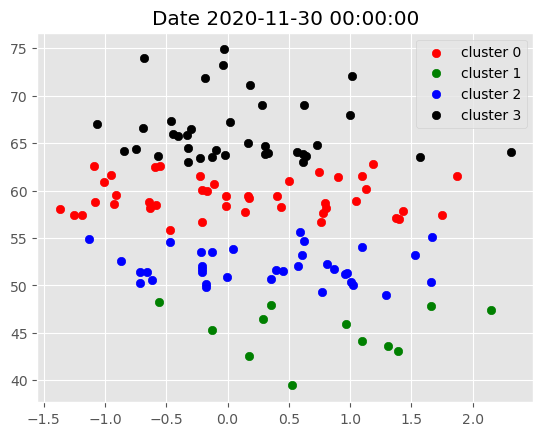

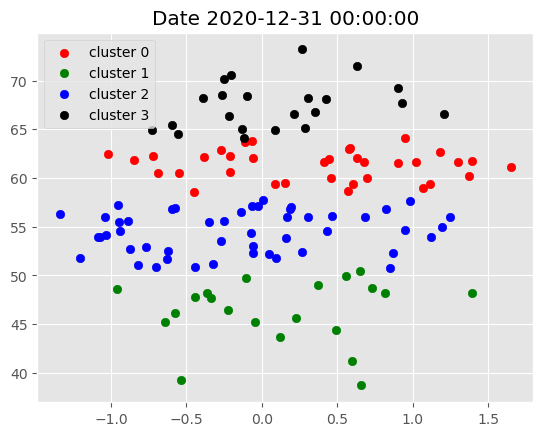

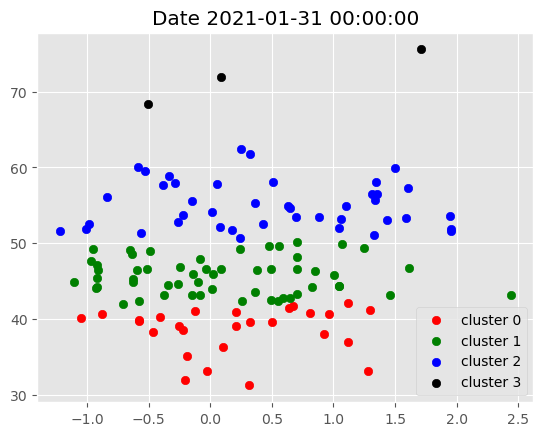

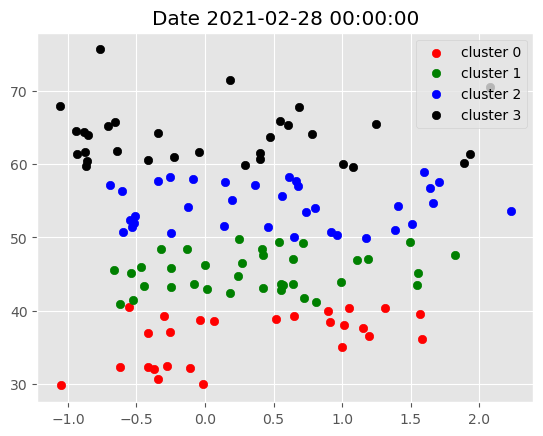

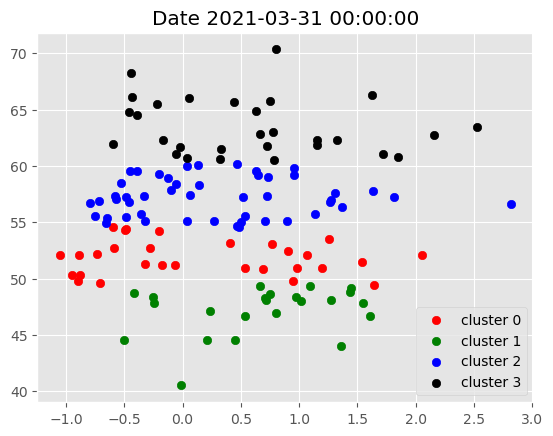

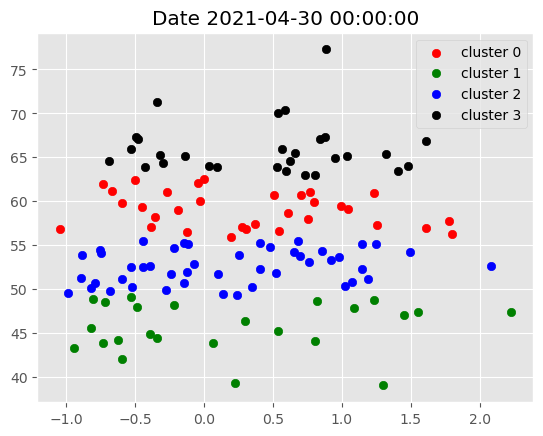

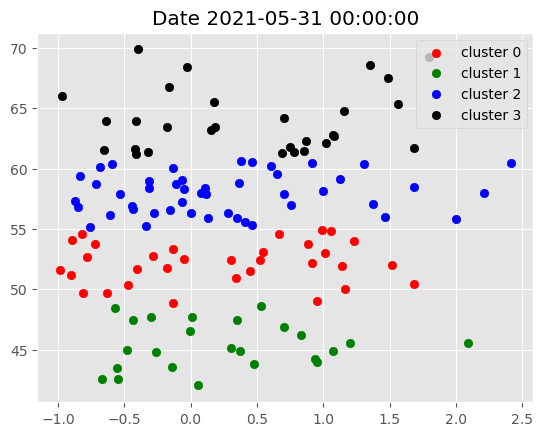

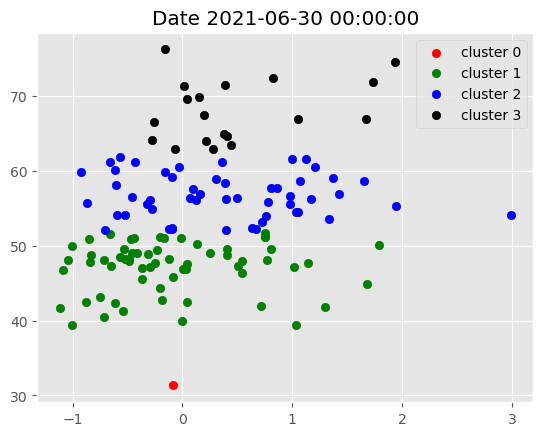

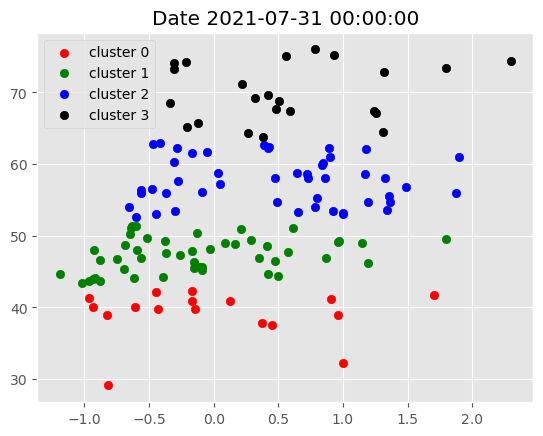

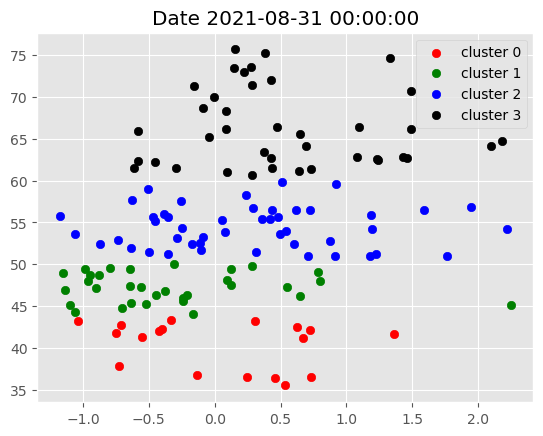

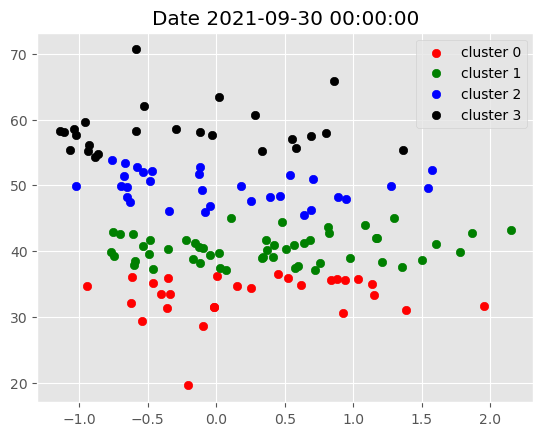

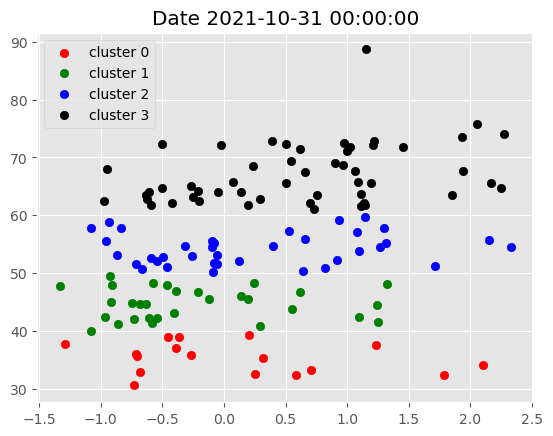

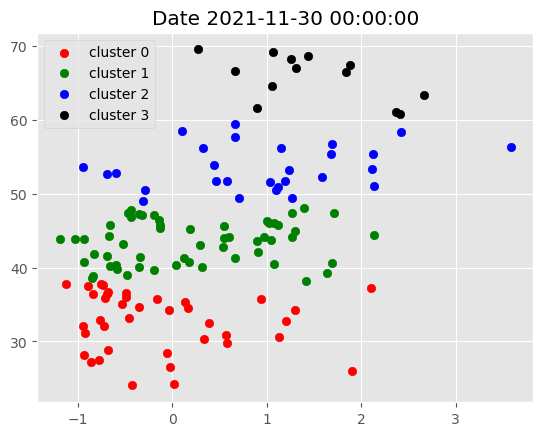

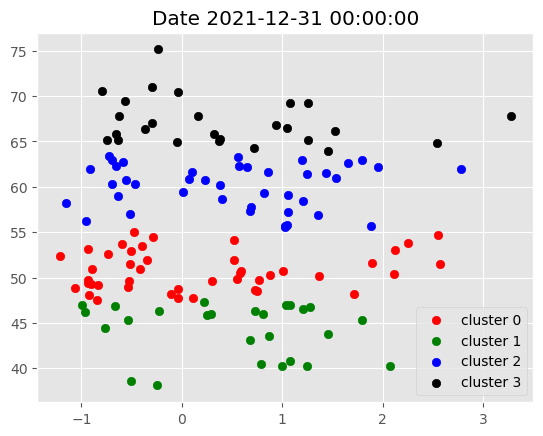

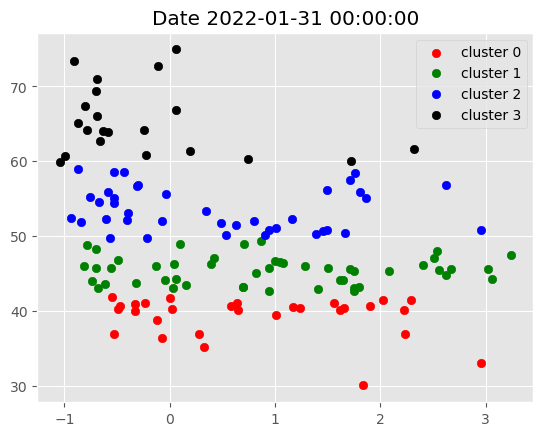

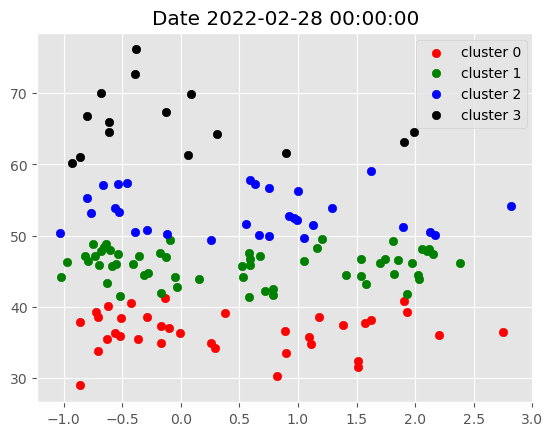

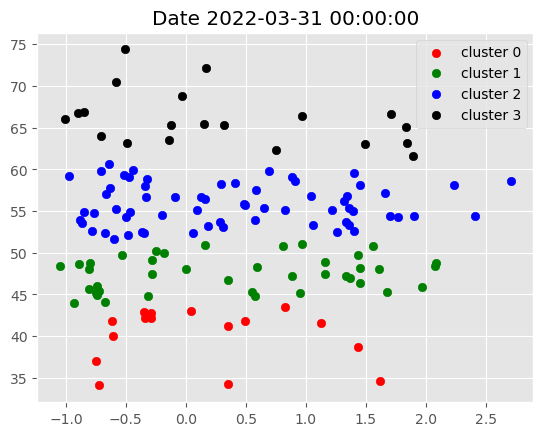

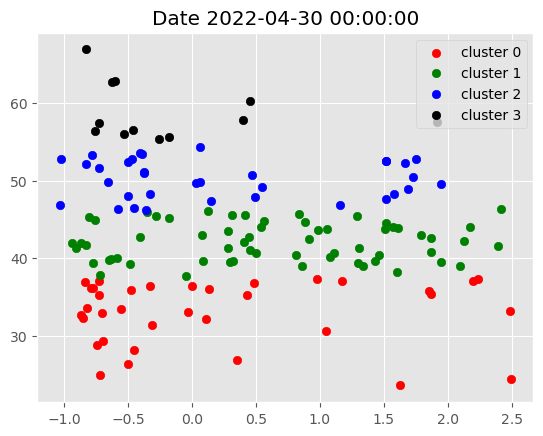

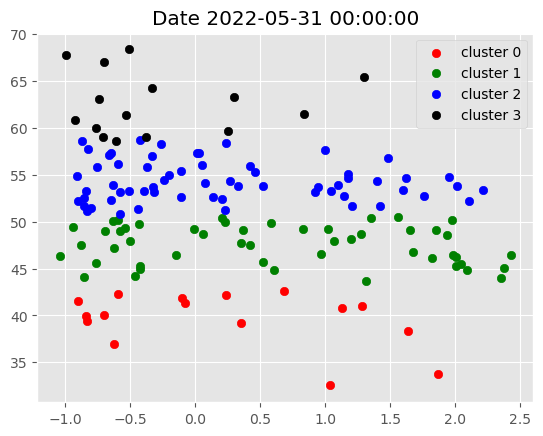

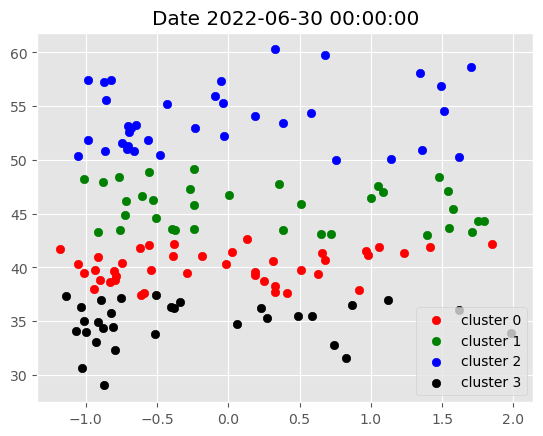

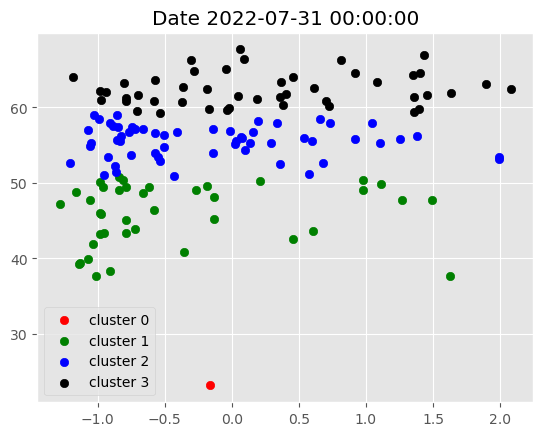

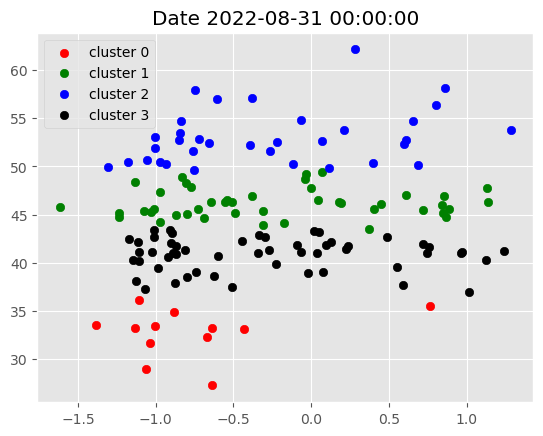

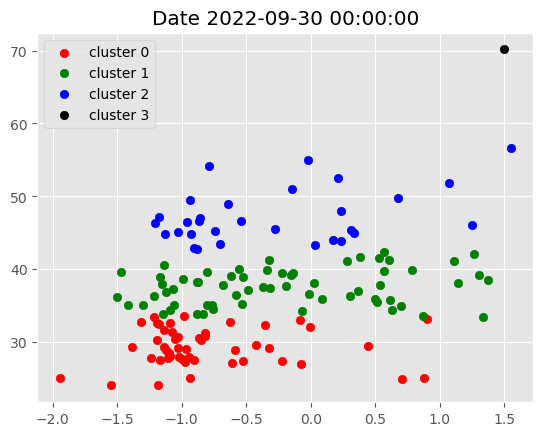

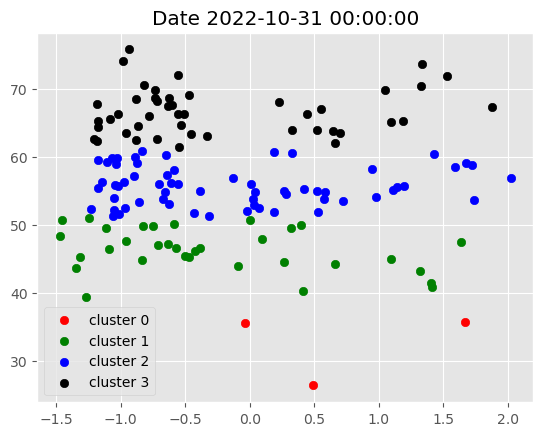

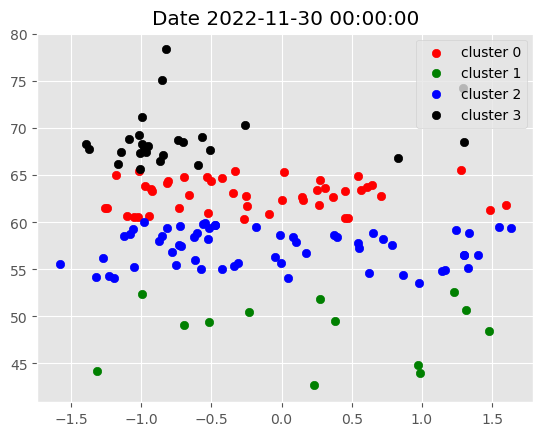

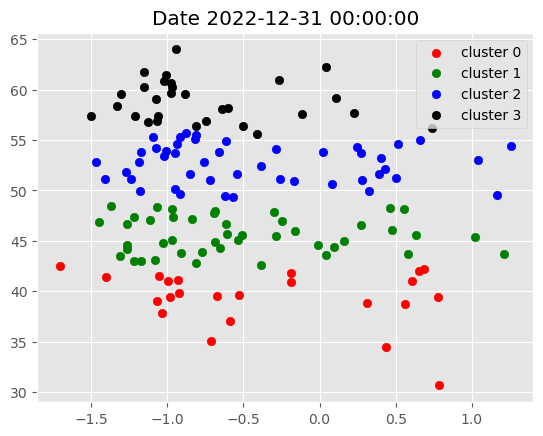

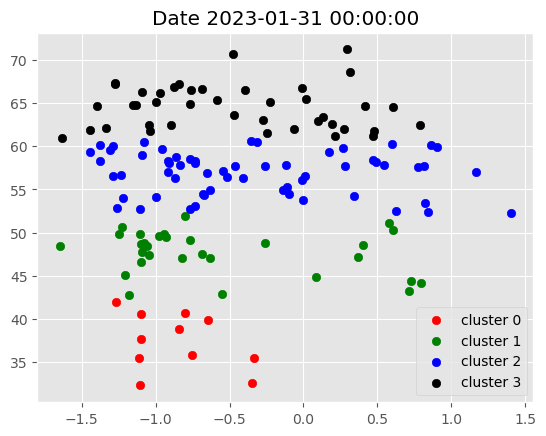

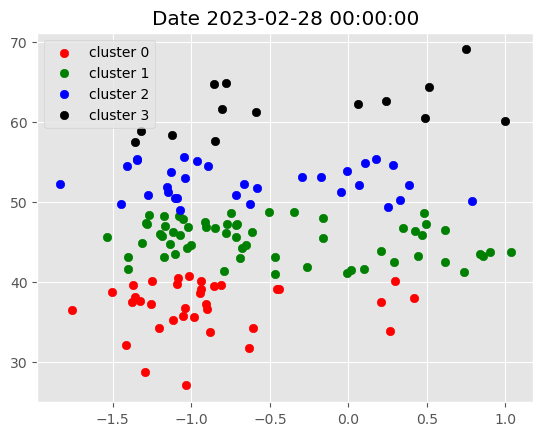

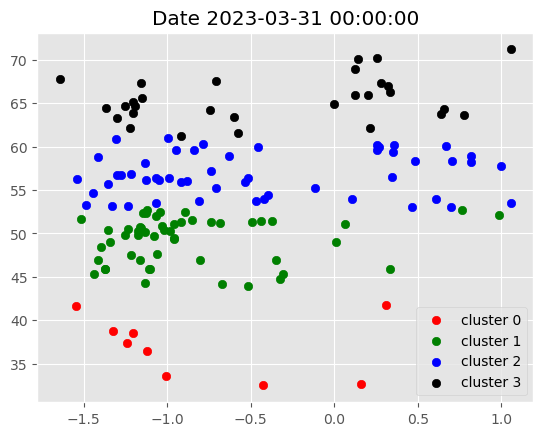

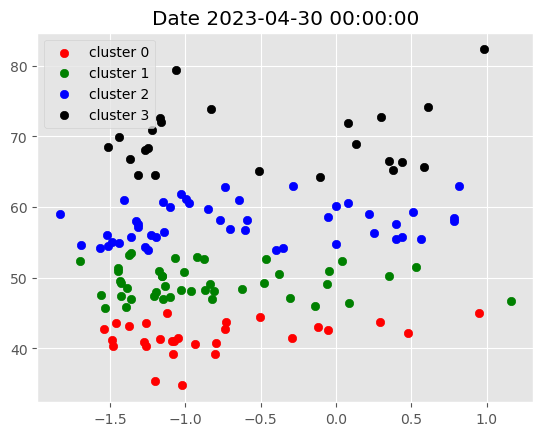

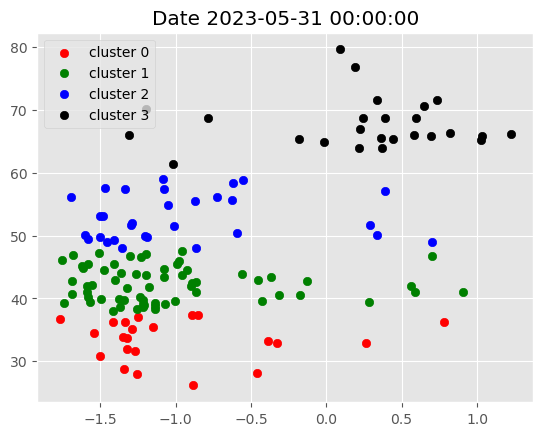

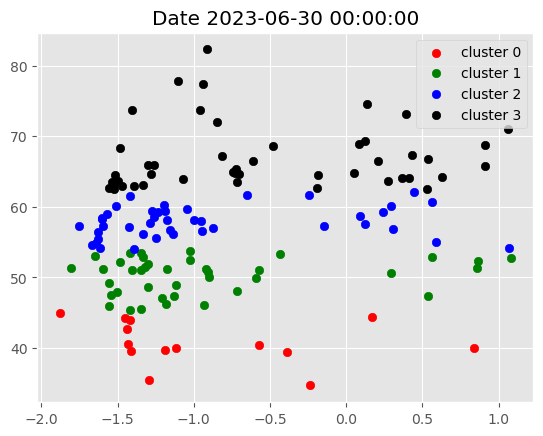

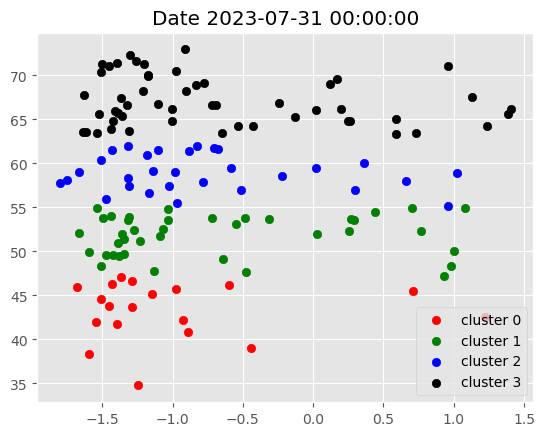

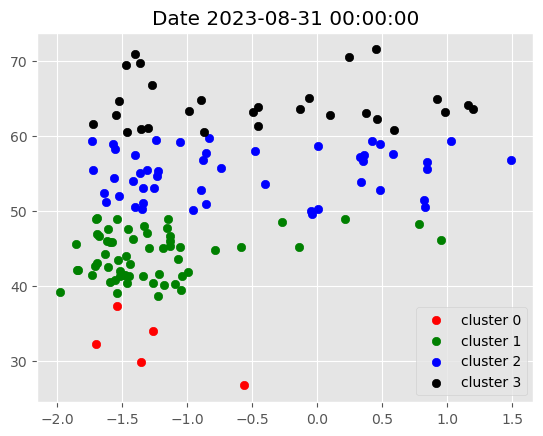

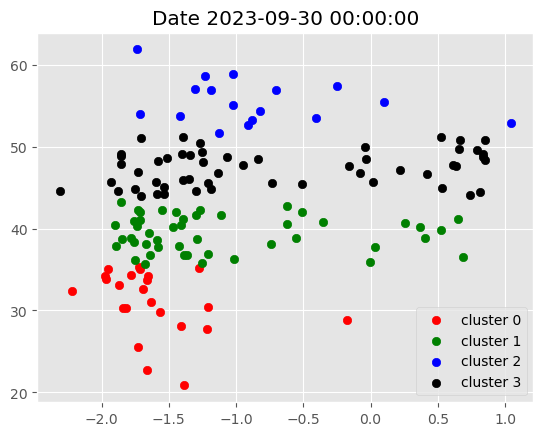

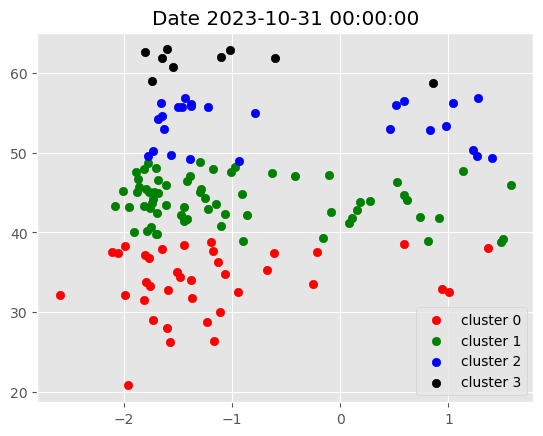

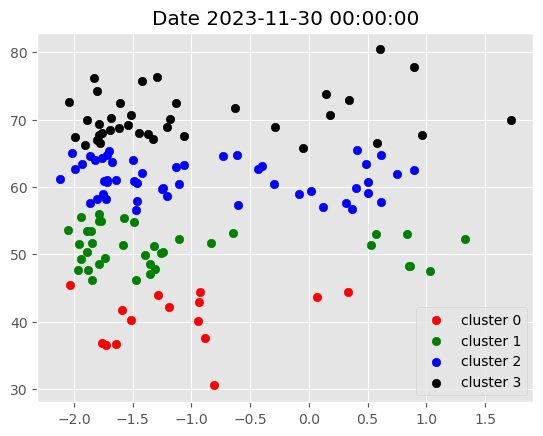

KeyboardInterrupt: 

In [185]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

Apply pre-defined centroids.

In [179]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

# This should be the RSI column
initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier Max Sharpe Ratio optimization
   1. First filter only stocks cluster we choose based on our hypothesis.
   2. Momentum is persistant and I believe that stocks clustered around RSI 70 centeroid should continue to outperform the market in the following month - thus I would select stocks corresponding to cluster 3 in my code.

In [187]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2020-11-01': ['ADP', 'DHR', 'DUK', 'GE', 'GM', 'SCHW', 'TMO'],
 '2020-12-01': ['ABBV',
  'ADP',
  'AMAT',
  'AMD',
  'AVGO',
  'BA',
  'BLK',
  'C',
  'CL',
  'COST',
  'CSCO',
  'DAL',
  'DE',
  'DIS',
  'EXPE',
  'F',
  'FCX',
  'GE',
  'GM',
  'GS',
  'HON',
  'LRCX',
  'MAR',
  'MS',
  'MU',
  'NKE',
  'NXPI',
  'OXY',
  'PANW',
  'PFE',
  'PNC',
  'SBUX',
  'SCHW',
  'TGT',
  'TSLA',
  'UAL',
  'WMT'],
 '2021-01-01': ['AVGO',
  'BAC',
  'BKNG',
  'C',
  'DD',
  'DIS',
  'EA',
  'EXPE',
  'FCX',
  'GS',
  'ISRG',
  'JNJ',
  'JPM',
  'LLY',
  'MS',
  'MU',
  'ORCL',
  'PANW',
  'PNC',
  'SBUX',
  'SCHW',
  'TSLA'],
 '2021-02-01': ['ABT', 'LLY', 'WBA'],
 '2021-03-01': ['AMAT',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CVX',
  'DAL',
  'DE',
  'EXPE',
  'F',
  'GE',
  'GS',
  'HAL',
  'JPM',
  'LLY',
  'LUV',
  'MAR',
  'MPC',
  'MS',
  'MU',
  'OXY',
  'PNC',
  'SBUX',
  'SCHW',
  'SLB',
  'SPG',
  'UAL',
  'VLO',
  'WFC',
  'WYNN',
  'XOM'],
 '2021-04-01': ['ACN',
  'ADP',
  'AMAT',


Define Portfolio Optimization Function

 1. We will define a function which will optimize portfolio weights according to PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.
 2. To optimize the weights of a given portfolio we would need to supply the last 1 year prices to the function.
 3. Apply single stock weight bonds constraint for diversification (minimum half of equally weight and maximum 10% of portfolio).

Efficient Frontier (Mean-Variance Optimizer) Docs: https://pyportfolioopt.readthedocs.io/en/latest/MeanVariance.html

In [303]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)

    #Covariance Matrix
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov, 
                           weight_bounds=(lower_bound, 0.1), 
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

    Downlead Fresh Daily Prices Data only for short listed stocks.

In [206]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12), 
                     end=data.index.get_level_values('date').unique()[-1], auto_adjust=False)

new_df

[*********************100%***********************]  144 of 144 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2019-10-31   59.966984   63.013054   75.877342  170.709793  277.929993   
2019-11-01   61.668896   64.755707   75.015182  173.287674  277.820007   
2019-11-04   62.073883   65.737938   74.615875  172.901001  277.500000   
2019-11-05   61.984688   64.826996   74.724777  172.053955  289.290009   
2019-11-06   62.011208   65.017113   75.432648  174.217514  287.399994   
...                ...         ...         ...         ...         ...   
2024-10-24  229.762360  186.157883  115.397087  360.899048  482.869995   
2024-10-25  230.599411  184.391037  113.099838  357.500366  483.720001   
2024-10-28  232.582443  186.187332  112.951309  358.015656  481.040009   
2024-10-29  232.851501  185.961578  112.287888  359.719910  485.390015   
2024-10-30  229.294006  197.789688  113.327576  343.400543  486.679993   

Price                                                                   ...  \
Ticker             ADI         ADP        ADSK        AMAT         AMD  ...   
Date                                                                    ...   
2019-10-31   96.438583  144.365524  147.360001   51.340378   33.930000  ...   
2019-11-01   98.916702  145.032928  150.250000   52.475811   34.889999  ...   
2019-11-04  100.743629  144.054077  151.270004   52.740738   36.290001  ...   
2019-11-05  102.606766  139.720291  151.729996   52.873196   36.150002  ...   
2019-11-06  101.322464  142.078491  151.509995   52.816441   35.930000  ...   
...                ...         ...         ...         ...         ...  ...   
2024-10-24  227.720810  286.411896  285.769989  182.379013  153.440002  ...   
2024-10-25  228.206635  284.957214  286.040009  185.128342  156.229996  ...   
2024-10-28  228.176895  283.453064  286.519989  183.957138  159.919998  ...   
2024-10-29  233.223465  284.947357  289.660004  188.701477  166.250000  ...   
2024-10-30  228.157059  289.726959  288.820007  183.917450  148.600006  ...   

Price        Volume                                                           \
Ticker            V      VLO     VRTX        VZ       WBA     WDAY       WFC   
Date                                                                           
2019-10-31  6830800  4396600  2273400  12226600   6970000  1151900  18814700   
2019-11-01  7000200  2843000  3010600   9629100   8239000  1096200  16359300   
2019-11-04  7154800  2482500  1293300  10133300  10758500  2048900  17559900   
2019-11-05  7447500  3286200  1324200  10645400  28677900  1301600  25965300   
2019-11-06  6992500  2529800  1124000   9287600  13655100  1216200  22051100   
...             ...      ...      ...       ...       ...      ...       ...   
2024-10-24  4679900  3784600   674000  23506400  19522100  1553300  18393300   
2024-10-25  4464600  2147800  1019700  19717400  18012300  1339900  14855500   
2024-10-28  4306200  2507700   501200  13575000  16275200  1259500  16158900   
2024-10-29  7534800  3901800   999500  15072300  17788500  1110000  13205500   
2024-10-30  9606800  2523500   722000  16372600  13504000   952700  16021700   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2019-10-31  14643900  1543700  16169100  
2019-11-01  11287800  1383800  14108700  
2019-11-04  13938000  2228900  15858200  
2019-11-05  12651300  1168000  14930400  
2019-11-06  10843200  2067300  13996500  
...              ...      ...       ...  
2024-10-24  11645900  1898100   9905600  
2024-10-25   8959400  1098500  10714600  
2024-10-28   7990200  1062200  11844500  
2024-10-29   9682400  1890200  14731000  
2024-10-30   9268800  1337100  12303700  

[1258 rows x 864 columns]

* Calculate daily returns for each stock which could end up in our portfolio
* Then loop over beginning of each month, select the stock for the month and calculate their weights for the next month.
* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.
* Calculated each day portfolio return.

In [603]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:
    
        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        cols = fixed_dates[start_date]
        
        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        
        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')\

        optimization_df = new_df['Adj Close'][optimization_start_date:optimization_end_date][cols]

        sucess = False

        try:
            weights = optimize_weights(prices=optimization_df, 
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))
            
            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                    index=optimization_df.columns.tolist(),
                                    columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]
        
        temp_df = temp_df.stack().to_frame ('return').reset_index(level=0)\
                .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                    left_index=True,
                    right_index=True)\
                .reset_index().set_index(['Date'])
        
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
        
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
        
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df #If Issues with data rep. arise, use other code form to get date and strat. Return

Max Sharpe Optimization failed for 2020-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights


,Strategy Return
Date,
2020-11-02,0.012744
2020-11-03,0.014801
2020-11-04,0.012567
2020-11-05,0.014613
2020-11-06,0.008252
...,...
2024-10-24,0.002446
2024-10-25,-0.008352
2024-10-28,0.002039


<Axes: xlabel='Date'>

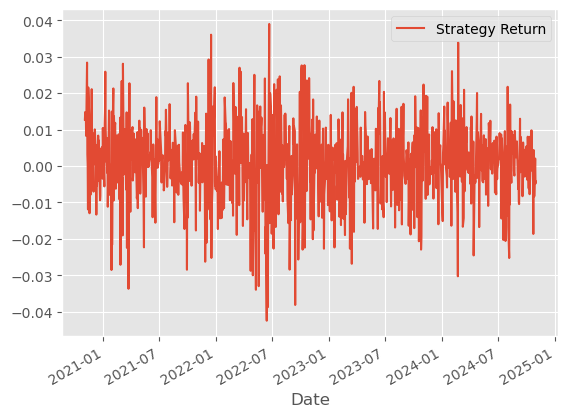

In [605]:
portfolio_df.plot()

8. Visualize Portfolio returns and compare to SP500 returns.

In [607]:
#run commented code only once while set up, otherwise extracolumns created
# spy = yf.download(tickers='SPY', start='2020-01-01', end=dt.date.today(), auto_adjust=False)

# spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

# spy_ret = spy_ret.reset_index()        # moves Date from index to a column

# # Flatten MultiIndex columns
# spy_ret.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in spy_ret.columns]

# # Rename properly
# spy_ret.columns = ['Date', 'SPY Buy&Hold']  # Rename explicitly

# # Set Date as index to match portfolio_df
# spy_ret = spy_ret.set_index('Date')

# # Merge the two on Date
# portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True, how='inner')

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
Date,,
2020-11-02,0.012744,0.011146
2020-11-03,0.014801,0.017502
2020-11-04,0.012567,0.022103
2020-11-05,0.014613,0.019315
2020-11-06,0.008252,-0.000228
...,...,...
2024-10-24,0.002446,0.002160
2024-10-25,-0.008352,-0.000345
2024-10-28,0.002039,0.003087


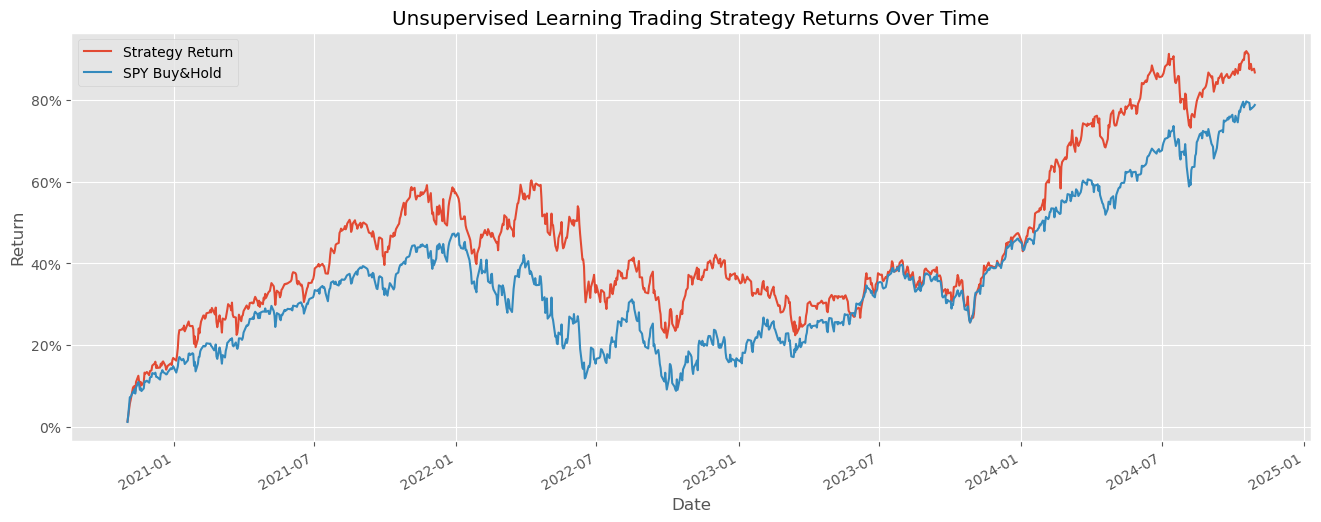

In [619]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-10-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()